In [48]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
pd.options.display.float_format = '{:,.2f}'.format # формат вывода чисел с плавающей точкой

# Разведывательный анализ данных

## Часть 0. Используемые функции и процедуры

### Процедура <i>percentage</i> строит датафрейм, показывающий распределение параметра <i>key_field</i> в заисимости от изменения параметра <i>obj</i>.
Строки датафрейма: значения или группы значений параметра <b>obj</b>.<br>
Поля датафрейма: количество значений параметра <b>key_field</b> в абсолютном и процентном виде,
а также количество строк с отсутствующимb значениями параметра <b>key_field</b>.<br>
Условие отбора по полю <b>obj</b> - параметр <b>cond</b>.

In [49]:
def percentage (df, obj, key_field, cond):
    
    # Обработка ошибок
    if (obj not in df.columns) or (key_field not in df.columns):
        print ('Error: wrong source dataset on input')
        return 0
    
    # Для поля 'score' делаем отдельный от других полей индекс для использования в параметре bins в value_counts   
    if obj == 'score': scale = [0,25,50,75,100]
    else: scale = None
        
    # Определяем количество уникальных признаков в key_field и second_obj
    x = len(df[key_field].value_counts())
    
    # Формируем двухуровневый список полей итогового датафрейма
    
    # Формируем первый уровень заголовков
    level_1 = ['with_data'] * (x+1)
    level_1.extend(['%']*x)
    level_1.extend(['without_data'])
    level_1.extend(['to_fill']*x)
    
    # Формируем второй уровень заголовков
    field_list = df[key_field].value_counts().index.tolist()
    level_2 = field_list + ['all'] + field_list + [''] + field_list

    # Формируем индекс итогового датафрейма и создаем датафрейм
    my_index = df[obj].value_counts(bins=scale).index.tolist()
    a = pd.DataFrame(index = my_index, columns = [level_1, level_2])
    a.sort_index (inplace=True)
    
    a['with_data','all'] = df[obj][~cond].value_counts(bins=scale) # Заполняем поле obj, исключая отсутствующие данные в key_field
    a['without_data',''] = df[obj][ cond].value_counts(bins=scale) # Заполняем поле obj из строк, где нет данных по полю key_field
    
    for i in range(x):
        a['with_data',level_2[i]] = df[obj][(~cond) & (df[key_field] == level_2[i])].value_counts(bins=scale)
        a['%'        ,level_2[i]] = a['with_data',level_2[i]] / a['with_data','all']
        a['to_fill'  ,level_2[i]] = round(a['without_data',''] * a['%',level_2[i]],0)
    
    display(a[['with_data']].sum(), a[['without_data']].sum(), a[['to_fill']].sum())
    return a

In [50]:
def out_ranges():
    flag = False
    for col in stud.columns:
        condition = (~stud[col].isin(threshold[col])) & (~stud[col].isna())
        if len(stud[condition]) != 0:
            print ('\nВылеты по полю ',col,':',sep='')
            display (stud[condition])
            flag = True
    if not flag: print ('Вылетов за устновленные границы диапазонов нет')
    return 0

In [51]:
def allocation (df, subject, obj, control, cond):
    a = df[[subject, obj, control]][~cond].groupby([subject, obj]).count()
    b = df[[subject, obj, control]][~cond].groupby([subject]).count()
    a['percentage'] = a[control].div(b[control], level = subject)
    a.rename(columns = {control: 'quantity'}, inplace=True)
    return a


def about_col(column):
    display (stud[column].value_counts())
    stud[[column]].info()

## Часть 1. Импорт и подготовка данных

In [52]:
# Открываем файл, смотрим описание полей датасета
stud = pd.read_csv('stud_math.csv')
stud.info()
display(stud.describe())
nan_values = stud[stud.columns].apply(lambda x: x.isna().sum())
display (nan_values)
print ('Всего отсутствуюет ',nan_values.sum(), ' значений.')
stud.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.00,392.00,371.00,367.00,388.00,373.00,388.00,368.00,384.00,387.00,380.00,383.00,389.00
mean,16.70,2.75,2.61,1.44,2.04,0.34,-6.12,3.94,3.23,3.11,3.53,7.28,52.26
std,1.28,1.10,2.23,0.69,0.84,0.74,2.53,0.93,0.99,1.12,1.40,23.47,22.92
min,15.00,0.00,0.00,1.00,1.00,0.00,-12.00,-1.00,1.00,1.00,1.00,0.00,0.00
25%,16.00,2.00,2.00,1.00,1.00,0.00,-6.00,4.00,3.00,2.00,3.00,0.00,40.00
50%,17.00,3.00,2.00,1.00,2.00,0.00,-6.00,4.00,3.00,3.00,4.00,4.00,55.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,-3.00,5.00,4.00,4.00,5.00,8.00,70.00
max,22.00,4.00,40.00,4.00,4.00,3.00,-3.00,5.00,5.00,5.00,5.00,385.00,100.00


school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Всего отсутствуюет  565  значений.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
303,GP,F,17,U,GT3,T,3.00,2.00,health,NaN,reputation,father,1.00,4.00,0.00,no,yes,yes,yes,no,-12.00,yes,yes,no,5.00,2.00,2.00,5.00,0.00,90.00
241,GP,M,17,NaN,LE3,A,4.00,4.00,teacher,other,course,mother,nan,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,yes,no,3.00,3.00,nan,4.00,2.00,60.00
198,GP,F,17,U,GT3,NaN,4.00,4.00,services,teacher,home,mother,2.00,1.00,1.00,no,yes,no,no,yes,-3.00,yes,NaN,no,4.00,2.00,4.00,2.00,24.00,90.00
369,MS,F,18,R,GT3,T,4.00,4.00,other,teacher,other,father,3.00,2.00,0.00,no,yes,yes,no,no,-6.00,yes,yes,yes,3.00,2.00,2.00,5.00,10.00,55.00
385,MS,F,18,R,GT3,T,2.00,2.00,at_home,other,other,NaN,nan,3.00,0.00,no,no,yes,no,yes,-9.00,yes,NaN,no,5.00,3.00,3.00,4.00,2.00,50.00
279,GP,M,18,U,LE3,T,4.00,3.00,teacher,services,course,NaN,2.00,1.00,0.00,no,NaN,NaN,yes,yes,-3.00,yes,yes,no,4.00,2.00,3.00,1.00,8.00,50.00
295,GP,M,17,U,GT3,T,3.00,3.00,health,other,home,mother,1.00,1.00,0.00,no,yes,yes,no,yes,-3.00,yes,yes,no,4.00,4.00,3.00,5.00,4.00,55.00


### Выводы по первому взгляду на данные:
1. Датасет небольшой: 395 строк.
2. Относительно большой объем отсутствующих данных: по некоторым полям (pstatus, paid) свыше 10%.
3. Датасет содержит 14 полей цифрового типа. Обратим на них повышенное внимание при обработке, будем смотреть распределение и выбросы.
3. Поле 'studytime, granular' не содержится в описании датасета - удаляем.
4. Ключевое поле (score) сожержит 6 пропусков - заполнять их бессмысленно т.к. это поле - итоговое для работы модели. Удаляем. 
5. Первые три поля (school, sex, age) не содержат ошибок - постараемся использовать для заполнения пропусков в других полях.
6. Поле score будем далее использовать как важный классификатор при заполнении отсутствующих данных и модель для контроля количество записей (строк) в датасете

In [53]:
# Удаляем 'studytime, granular'
stud.drop(['studytime, granular'], axis=1, inplace=True)

### Проверим данные на выбросы за рамки здравого смысла
Создадим справочник допустимых значений по каждому из полей датафрейма на основе описания 

In [54]:
threshold = {
    'school': ['GP', 'MS'],
    'sex': ['F', 'M'],
    'age': range(15,23),
    'address': ['R', 'U'],
    'famsize': ['GT3', 'LE3'],
    'Pstatus': ['T', 'A'],
    'Medu': range(0,5),
    'Fedu': range(0,5),
    'Mjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'Fjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'reason':['home', 'reputation', 'course', 'other'],
    'guardian': ['mother', 'father', 'other'],
    'traveltime': range(1,5),
    'studytime': range(1,5),
    'failures': range(0,4),
    'schoolsup': ['yes','no'],
    'famsup': ['yes','no'],
    'paid': ['yes','no'],
    'activities': ['yes','no'],
    'nursery': ['yes','no'],
    'higher': ['yes','no'],
    'internet': ['yes','no'],
    'romantic': ['yes','no'],
    'famrel': range(1,6),
    'freetime': range(1,6),
    'goout': range(1,6),
    'health': range(1,6),
    'absences': range (0,191),
# принимаем продолжительность учебногогода в 38-39 недель; пропусков не может быть больше
# https://www.estudy.ru/important-to-know/articles/view/42-shkolnyi-god-uchebnyi-den-v-shkole-v-velikobritanii.htm
    'score': range(0,101)}

Проверим датафрейм на выбросы за рамки установленных шкал (пока без учета незаполненных значений)

In [55]:
out_ranges()


Вылеты по полю Fedu:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.00,40.00,services,other,reputation,father,3.00,3.00,0.00,no,yes,no,yes,yes,yes,yes,no,5.00,2.00,2.00,4.00,4.00,60.00



Вылеты по полю famrel:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.00,2.00,services,services,home,mother,1.00,1.00,2.00,no,yes,yes,no,no,yes,yes,no,-1.00,2.00,2.00,5.00,14.00,40.00



Вылеты по полю absences:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.00,3.00,services,teacher,other,mother,1.00,2.00,0.00,yes,NaN,no,no,yes,yes,yes,no,2.00,3.00,1.00,3.00,385.00,85.00
390,MS,M,20,U,LE3,A,2.00,2.00,services,services,course,NaN,1.00,2.00,2.00,no,yes,yes,no,yes,yes,no,no,5.00,5.00,4.00,4.00,212.00,45.00


0

1. Вылет по полю fedu: 40. Допустимый диапазон: от 0 до 4. Очевидно, это опечатка, необходимо заменить на 4. <br>
2. Вылет по полю famrel: -1. Допустимый диапазон: от 1 до 5. Возможно, опечатка; меняем на 1. <br>
3. Два вылета по полю absences: 385 и 212. В качестве допустимого диапазона принят интервал от 0 до 190: максимальное количество учебных дней исходя из 38 учебных недель. Удаляем эти значения, оставляя пропуски (NaN).

In [56]:
stud['Fedu'] = np.where(stud['Fedu'] == 40, 4, stud['Fedu'])
stud['famrel'] = np.where(stud['famrel'] == -1, 1, stud['famrel'])
stud['absences'] = np.where(stud['absences'] == 385, np.nan, stud['absences'])
stud['absences'] = np.where(stud['absences'] == 212, np.nan, stud['absences'])

In [57]:
# Проверяем, что получилось:
out_ranges ()

Вылетов за устновленные границы диапазонов нет


0

### Обрабатываем клюбчевой поле <i> score

In [58]:
# Ключевое поле - score - содержит 389 цифровых значений из 395. Смотрим на 6 отсавшихся строк: 
stud[stud['score'].isna()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2.00,3.00,other,other,reputation,mother,1.00,2.00,0.00,yes,yes,NaN,yes,yes,yes,no,no,4.00,nan,3.00,4.00,6.00,nan
244,GP,F,18,U,GT3,T,2.00,1.00,other,other,course,other,2.00,3.00,0.00,no,yes,yes,no,no,yes,yes,yes,4.00,4.00,4.00,3.00,0.00,nan
270,GP,F,19,NaN,GT3,T,3.00,3.00,other,services,home,other,1.00,2.00,2.00,no,yes,yes,yes,yes,yes,yes,no,4.00,3.00,5.00,5.00,nan,nan
283,GP,F,18,U,GT3,T,1.00,1.00,other,other,home,mother,2.00,2.00,0.00,yes,NaN,no,yes,yes,yes,yes,no,5.00,nan,4.00,4.00,4.00,nan
312,GP,M,19,U,GT3,T,1.00,2.00,other,services,course,other,1.00,2.00,1.00,no,no,no,no,no,yes,yes,no,4.00,5.00,nan,4.00,3.00,nan
350,MS,M,19,NaN,GT3,T,1.00,1.00,other,services,home,other,3.00,2.00,3.00,no,no,no,no,NaN,yes,yes,no,5.00,4.00,4.00,2.00,8.00,nan


In [59]:
# Удаляем строки с NaN в поле score
condition = stud['score'].isna()
stud = stud[~condition]

In [60]:
# Проверяем, что получилось
print('Пропусков в поле "score": %d. Записей в датасете: %d' % (stud['score'].isna().sum(), stud['school'].count()))

Пропусков в поле "score": 0. Записей в датасете: 389


(80.0, 100.0]    0.06
(-0.101, 20.0]   0.10
(20.0, 40.0]     0.16
(60.0, 80.0]     0.28
(40.0, 60.0]     0.41
Name: score, dtype: float64

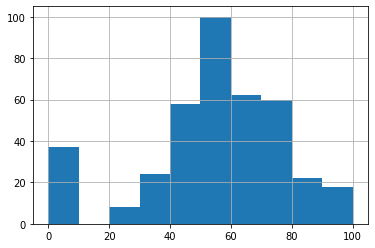

In [61]:
# Посмотрим на распределение значений в поле 'score'
stud['score'].hist()
stud['score'].value_counts(bins=5, normalize=True, ascending=True)

Обращаем внимание на нормальное распределение признака за исключением нескольких нулевых значений. Наибольшее количество значений укладывается в диапазон от 40 до 80.

### Обработка поля address

In [62]:
field = 'address'
condition = stud[field].isna()

In [63]:
# Посмотрим на рспределение адресов в заисимости от школы 
s = percentage (stud, 'school', field, condition)
s

with_data  U      291
           R       83
           all    374
dtype: int64

without_data      15
dtype: int64

to_fill  U   11.00
         R    4.00
dtype: float64

with_data             %      without_data to_fill     
           U   R  all    U    R                    U    R
GP       273  60  333 0.82 0.18           11    9.00 2.00
MS        18  23   41 0.44 0.56            4    2.00 2.00

Основная часть студентов школы GP (82%) живет в городе (U), тогда как в школе MS
адреса студентов распределены примерно поровну.

In [64]:
# Посмотрим на рспределение адресов в заисимости от итоговых баллов
s = percentage (stud, 'score', field, condition)
s

with_data  U      291
           R       83
           all    374
dtype: int64

without_data      15
dtype: int64

to_fill  U   12.00
         R    3.00
dtype: float64

with_data             %      without_data to_fill     
                       U   R  all    U    R                    U    R
(-0.001, 25.0]        30  14   44 0.68 0.32            1    1.00 0.00
(25.0, 50.0]          98  35  133 0.74 0.26            3    2.00 1.00
(50.0, 75.0]         131  27  158 0.83 0.17           10    8.00 2.00
(75.0, 100.0]         32   7   39 0.82 0.18            1    1.00 0.00

На основе полученных результатов сделаем следующие допущения: значение U ставим для 11 студентов, R для 4. <br><br>
Назначаем адрес U:
- 1 студент из школы GP с баллами ниже 25;
- 2 студента из школы GP с баллами от 25 до 50;
- 6 студентов из школы GP с баллами от 50 до 75;
<br><br>
- 2 студента из школы MS с баллами от 50 до 75;
<br><br>
<b> Итого: (1+2+6+2) 11-и студентам назначаем адрес U (9 студентов из школы GP, 2 студента из школы MS.)<br>

Назначаем адрес R:
- 1 студент из школы GP с баллами от 25 до 50;
- 1 студента из школы GP с баллами от 50 до 75;
<br><br>
- 2 студент из школы MS с баллами от 50 до 75;
<br><br>
<b> Итого: (1+1+2) 4-и студентам назначаем адрес R (2 из GP, 2 из MS). 

In [65]:
bin1 = stud[(condition) & (stud['school'] == 'GP') & (stud['score'] < 25)].copy()
bin1['address'].fillna('U', inplace = True)

bin2 = stud[(condition) & (stud['school'] == 'GP') & (stud['score'] > 25) & (stud['score'] <= 50)].iloc[0:2].copy()
bin2['address'].fillna('U', inplace = True)

bin3 = stud[(condition) & (stud['school'] == 'GP') & (stud['score'] > 25) & (stud['score'] <= 50)].iloc[2:3].copy()
bin3['address'].fillna('R', inplace = True)

bin4 = stud[(condition) & (stud['school'] == 'GP') & (stud['score'] > 50) & (stud['score'] <= 75)].iloc[0:6].copy()
bin4['address'].fillna('U', inplace = True)

bin5 = stud[(condition) & (stud['school'] == 'GP') & (stud['score'] > 50) & (stud['score'] <= 75)].iloc[6:7].copy()
bin5['address'].fillna('R', inplace = True)

bin6 = stud[(condition) & (stud['school'] == 'MS') & (stud['score'] > 50) & (stud['score'] <= 75)].iloc[0:2].copy()
bin6['address'].fillna('U', inplace = True)

bin7 = stud[(condition) & (stud['school'] == 'MS') & (stud['score'] > 50) & (stud['score'] <= 75)].iloc[2:3].copy()
bin7['address'].fillna('R', inplace = True)

bin8 = stud[(condition) & (stud['school'] == 'MS') & (stud['score'] > 75)].copy()
bin8['address'].fillna('R', inplace = True)

stud = pd.concat([stud,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8])

In [66]:
condition = stud[field].isna()
stud = stud[~condition]

In [67]:
# Проверяем, что получилось
print('Пропусков в поле "address": %d. Записей в датасете: %d' % (stud['address'].isna().sum(), stud['school'].count()))

Пропусков в поле "address": 0. Записей в датасете: 389


### Обработка поля famsize

In [68]:
field = 'famsize'
condition = stud[field].isna()
condition.sum() # определяем количествопропущенных данных

27

In [69]:
# Посмотрим на рспределение famsize в заисимости от итоговых баллов
s = percentage (stud, 'score', field, condition)
s

with_data  GT3    255
           LE3    107
           all    362
dtype: int64

without_data      27
dtype: int64

to_fill  GT3   19.00
         LE3    8.00
dtype: float64

with_data             %      without_data to_fill     
                     GT3 LE3  all  GT3  LE3                  GT3  LE3
(-0.001, 25.0]        33   8   41 0.80 0.20            4    3.00 1.00
(25.0, 50.0]          84  39  123 0.68 0.32           13    9.00 4.00
(50.0, 75.0]         115  47  162 0.71 0.29            6    4.00 2.00
(75.0, 100.0]         23  13   36 0.64 0.36            4    3.00 1.00

Распределение студентов по размеру семьи в каждой из подгрупп примерно 70/30  

In [70]:
# Посмотрим на рспределение famsize в заисимости от школы
s = percentage (stud, 'school', field, condition)
s

with_data  GT3    255
           LE3    107
           all    362
dtype: int64

without_data      27
dtype: int64

to_fill  GT3   19.00
         LE3    8.00
dtype: float64

with_data             %      without_data to_fill     
         GT3 LE3  all  GT3  LE3                  GT3  LE3
GP       228  91  319 0.71 0.29           25   18.00 7.00
MS        27  16   43 0.63 0.37            2    1.00 1.00

Такое же соотношение: 70/30. Так и разделим: из 27 отсутствующих данных 18 назначим признак GT3, отсавшимся - LE3 

In [71]:
bin1 = stud[(condition)].iloc[0:19].copy()
bin1[field].fillna('GT3', inplace = True)

bin2 = stud[(condition)].iloc[19:28].copy()
bin2[field].fillna('LE3', inplace = True)

stud = pd.concat([stud,bin1,bin2])

In [72]:
condition = stud[field].isna()
stud = stud[~condition]

In [73]:
# Проверяем, что получилось
print('Пропусков в поле "famsize": %d. Записей в датасете: %d' % (stud[field].isna().sum(), stud['school'].count()))

Пропусков в поле "famsize": 0. Записей в датасете: 389
